<a href="https://colab.research.google.com/github/sayid-alt/sentiment-analysis-nlp/blob/rnn-cnn-comparing/dev/Sentiment_analyst_prediction_with_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset: [kaggle](https://www.kaggle.com/datasets/damirolejar/sentiment-analysis-nlp-trainset-data?select=final_negative.txt)

See copied project on [github](https://github.com/sayid-alt/sentiment-analysis-nlp)

# Import library

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Embedding, Flatten, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam

from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score, precision_recall_curve,precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize

from google.colab import files

import os
import zipfile
import urllib.request

# Utilities

In [2]:
DOWNLOAD_URL = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/data/text.zip'
DOWNLOAD_DIR = os.path.join(os.getcwd(), 'datasets')

def download_data(url=DOWNLOAD_URL, dir=DOWNLOAD_DIR):
    # Downloading data
    print('Downloading data...')
    if not os.path.exists(dir):
        os.makedirs(dir)

    zip_path = os.path.join(dir, 'text.zip')
    urllib.request.urlretrieve(url, zip_path)
    print(f'Success downloading data to {zip_path}')

    # Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'Success extracting data to {dir}')


# prep data from text file to variable in list type
def prep_data_txt(filepath):
  '''
    filepath: path for text file
    return: list of text
  '''
  datalist = []
  with open(filepath, 'r') as file:
    lines = file.readlines()
    for line in lines:
      datalist.append(line.strip())
  return datalist

# retrieve data
def retrieve_sentiment_data():
  '''
    return: neg_text, pos_text, ne_text as the dataset for sentiment analysis
  '''
  neg_text = prep_data_txt(os.path.join(data_dir, 'final_negative.txt')) #negative data
  pos_text = prep_data_txt(os.path.join(data_dir, 'final_positive.txt'))# positif data
  ne_text = prep_data_txt(os.path.join(data_dir, 'final_neutral.txt'))

  print(f'Negative data length: {len(neg_text)}')
  print(f'Positive data length: {len(pos_text)}')
  print(f'neutral data length: {len(ne_text)}')

  print(f'Negative data sample: {neg_text[:5]}')
  print(f'Positive data sample: {pos_text[:5]}')
  print(f'neutral data sample: {ne_text[:5]}')

  return neg_text, pos_text, ne_text


def stratified_split(df):
  # split data using stratified with size train/val/test 80/10/10 respectively
  df_train, df_test = train_test_split(df,
                                       test_size=0.2,
                                       random_state=42,
                                       stratify=df['label'])


  # split throug test size for get validation split
  df_val, df_test = train_test_split(df_test,
                                     test_size=0.5,
                                     random_state=42,
                                     stratify=df_test['label'])

  value_count = df['label'].value_counts()
  train_count = df_train['label'].value_counts()
  val_count = df_val['label'].value_counts()
  test_count = df_test['label'].value_counts()

  print(f'Value count:\n{value_count}')
  print(f'-----------\nTrain count:\n{train_count}')
  print(f'Val count:\n{val_count}')
  print(f'Test count:\n{test_count}')

  return df_train, df_val, df_test

def check_distribution(labels,
                       title=None,
                       xlabel='Labels',
                       ylabel='Frequency'
                       ):
  plt.figure(figsize=(5, 4))
  sns.histplot(labels, bins=3, color='skyblue')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

def check_split_distribution(labels):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

  for i, label in enumerate(labels):
    label.hist(ax=ax[i], bins=3, color='skyblue')
    ax[i].set_xlabel('Labels')
    ax[i].set_ylabel('Frequency')
  plt.show()

# Plot utility
def plot_graphs(history, strings=['accuracy', 'loss']):
  fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

  for i, string in enumerate(strings):
    ax[i].plot(history.history[string])
    ax[i].plot(history.history['val_'+string])

    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(string)
    ax[i].legend([string, 'val_'+string])
    ax[i].set_title('History Model in Epochs')

  plt.show()

def plot_compare_graphs(models, model_names, title, strings=['accuracy', 'loss']):
  # Sample accuracy data for two models (replace these with your actual values)
  epochs = range(1, 11)  # Assuming training for 10 epochs

  # main colors plot [acc, loss]
  colors = ['darkorange', 'darkgreen', 'dodgerblue']
  # val colors plot [val_acc, val_loss]
  val_colors = ['burlywood', 'darkseagreen', 'skyblue']

  # Plot the data
  fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

  for i in range(len(models)):
    for j, string in enumerate(strings):
      ax[j].plot(epochs, models[i].history[string], label=f'{model_names[i]} Training {string}', color=colors[i], marker='o', linestyle='-')
      ax[j].plot(epochs, models[i].history['val_'+string], label=f'{model_names[i]} Validation {string}', color=val_colors[i], marker='o', linestyle='-')

      ax[j].set_xlabel("Epochs")
      ax[j].set_ylabel(string)
      ax[j].legend()
      ax[j].set_title(f'Model History in Epochs of {string}')

  plt.show()

def lr_history_plot(lr_models, lr_names):
  # Sample accuracy data for two models (replace these with your actual values)
  epochs = range(1, 11)  # Assuming training for 10 epochs

  # main colors plot [acc, loss]
  colors = ['darkorange', 'darkgreen', 'dodgerblue']

  # Plot the data
  fig, ax = plt.subplots(figsize=(8, 4), nrows=1)

  for i in range(len(lr_models)):
    ax.plot(epochs, lr_models[i].lr_history, label=f'{lr_names[i]}',
               color=colors[i], marker='o', linestyle='-')

  ax.set_xlabel("Epochs")
  ax.set_ylabel("Learning_rate")
  ax.legend()
  ax.set_title(f'Learning Rate History in Epochs')

  plt.show()


# Download data

In [3]:
download_data()

Success downloading data to /content/datasets/text.zip
Success extracting data to /content/datasets


# Generate Data

In [4]:
data_dir = os.path.join(DOWNLOAD_DIR, 'text')
print(os.listdir(data_dir))

['final_positive.txt', 'final_neutral.txt', 'final_negative.txt']


In [5]:
neg_text, pos_text, ne_text = retrieve_sentiment_data()

Negative data length: 99999
Positive data length: 100000
neutral data length: 99999
Negative data sample: ['Mothers will not give their sons as sacrifices upon the battlefield after twenty years of anxiety and loving devotion in rearing them from infancy, no matter what cause they are called upon to defend.', 'That which was meant to be conducive to life has become the cause of death; that which should have been an evidence of knowledge is now a proof of ignorance; that which was a factor in the sublimity of human nature has proved to be its degradation.', 'The Jews were expecting the appearance of the Messiah, looking forward to it with devotion of heart and soul, but because they were submerged in imitations, they did not believe in Jesus Christ when He appeared.', 'We have forsaken the path of God; we have given up attention to the divine Kingdom; we have not severed the heart from worldly attractions; we have become defiled with qualities which are not praiseworthy in the sight of 

# Data Preprocessing

## Distribution

Below we merge all data into 3 sentiment categories:
- 0: Negative sentiment
- 1: Positif sentiment
- 2: neutral sentimen

In [6]:
df = pd.DataFrame({
    'sentiment' : neg_text + pos_text + ne_text,
    'label' : ['negative'] * len(neg_text) + ['positive'] * len(pos_text) + ['neutral'] * len(ne_text)
})
df.head()

,sentiment,label
0,Mothers will not give their sons as sacrifices...,negative
1,That which was meant to be conducive to life h...,negative
2,The Jews were expecting the appearance of the ...,negative
3,We have forsaken the path of God; we have give...,negative
4,"Sixth, the Messiah was to gather together all ...",negative


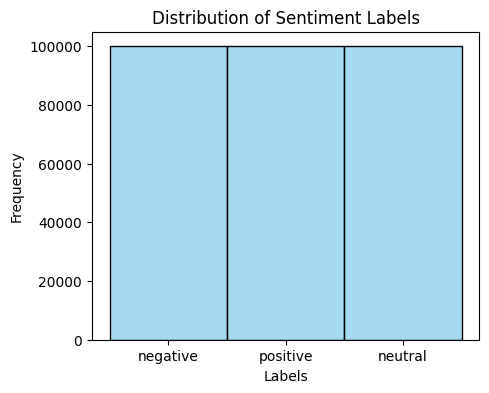

In [7]:
check_distribution(df['label'], 'Distribution of Sentiment Labels')

## Split data

Split data, using stratified shuffle split from sklearn []:
- Train: 80
- Val: 10
- test: 10

In [8]:
# split data using stratified with size train/val/test 80/10/10 respectively
df_train, df_val, df_test = stratified_split(df)

Value count:
label
positive    100000
negative     99999
neutral      99999
Name: count, dtype: int64
-----------
Train count:
label
positive    80000
neutral     79999
negative    79999
Name: count, dtype: int64
Val count:
label
positive    10000
negative    10000
neutral     10000
Name: count, dtype: int64
Test count:
label
negative    10000
neutral     10000
positive    10000
Name: count, dtype: int64


In [9]:
df_train.head(), df_val.head(), df_test.head()

(                                                sentiment     label
 232194  Look at Michael Angelo; poet, painter, sculpto...   neutral
 143208  The story of how Charlemagne dealt with these ...  positive
 124048  It lies in a pleasant undulating district near...  positive
 92224   But the painted foliage on these crags!-the Gr...  negative
 167924  The labor devolving upon him as the commander ...  positive,
                                                 sentiment     label
 160313  In the first volume of the series, entitled Th...  positive
 8888    How jolly it will be, for all but the bad ange...  negative
 219510  154), that the grand conception of a Supreme U...   neutral
 185958  Of course, we hope that you will support the P...  positive
 157285  Lahoma seated herself eagerly and looking up i...  positive,
                                                 sentiment     label
 98454   Just as I had finished our hut, it occurred to...  negative
 47819   No, sir; couldn't move-

## Checking for split distribution

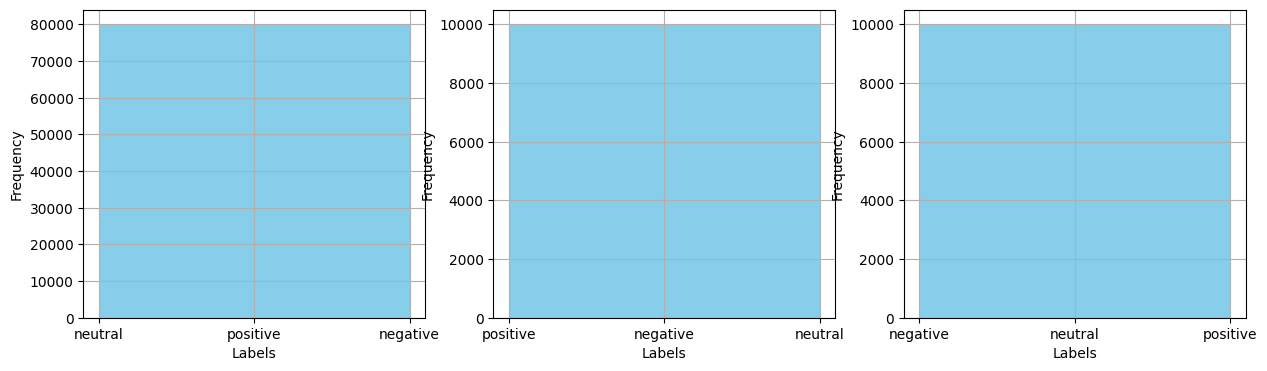

In [10]:

dfs_label = [df_train['label'], df_val['label'], df_test['label']]

check_split_distribution(dfs_label)

In [11]:
# check the size of each split
len_df = len(df)
len_train = len(df_train)
len_val = len(df_val)
len_test = len(df_test)

print(f'Train data size: {round(len_train/len_df,2)}')
print(f'Val data size: {round(len_val/len_df,2)}')
print(f'Test data size: {round(len_test/len_df,2)}')

Train data size: 0.8
Val data size: 0.1
Test data size: 0.1


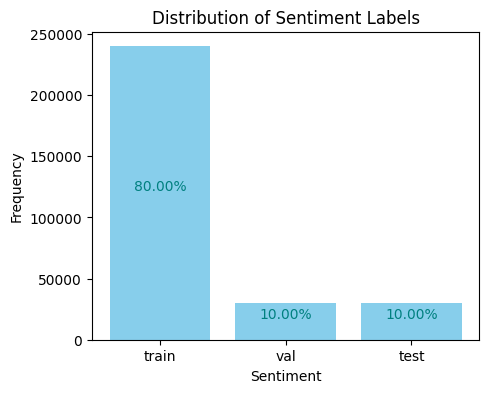

In [12]:
split_name = ['train', 'val', 'test']
split_df = [len_train, len_val, len_test]

plt.figure(figsize=(5, 4))
bars = plt.bar(x=split_name, height=split_df, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height - (height/2.0), '%0.2f%s' % ((height/len_df)*100, '%'), ha='center', va='bottom', color='teal')

plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

## Preparation for training

In [13]:
# split for training portion
X_train, y_train = df_train['sentiment'], df_train['label']
X_val, y_val = df_val['sentiment'], df_val['label']
X_test, y_test = df_test['sentiment'], df_test['label']

In [14]:
# X_train.to_csv('X_train.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# X_val.to_csv('X_val.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)


In [15]:
# try:
#   from google.colab import files
# except e:
#   print(e)
# else:
#   files.download('X_train.csv')
#   files.download('y_train.csv')
#   files.download('X_val.csv')
#   files.download('y_val.csv')
#   files.download('X_test.csv')
#   files.download('y_test.csv')

### Hyperparameters

In [16]:
# Vocabulary size of the tokenizer
vocab_size = 50000

# Maximum length of the padded sequences
max_length = 100

# Output dimensions of the Embedding layer
embedding_dim = 250

### Tokenize data

In [17]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [18]:
print(len(word_index))

122232


In [19]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)
label_index_word = label_tokenizer.index_word

# start encoder label from 0
labels_encoder = {key - 1: value for key, value in label_index_word.items()}

# Tokenize the label
training_labels = label_tokenizer.texts_to_sequences(y_train)
val_labels = label_tokenizer.texts_to_sequences(y_val)
test_labels = label_tokenizer.texts_to_sequences(y_test)

In [20]:
print(labels_encoder)
np.unique(y_test)

{0: 'positive', 1: 'neutral', 2: 'negative'}


array(['negative', 'neutral', 'positive'], dtype=object)

In [21]:
# convert labels list to np array
# Below arrays are subtracted by one, because all index should start from 0, instead the current label before subtract started with one
training_labels = np.array(training_labels) - 1
val_labels = np.array(val_labels) - 1
test_labels = np.array(test_labels) - 1

In [22]:
print(f'label training shape\t : {training_labels.shape}')
print(f'label val shape\t\t : {val_labels.shape}')
print(f'label test shape\t : {test_labels.shape}')

label training shape	 : (239998, 1)
label val shape		 : (30000, 1)
label test shape	 : (30000, 1)


### Sequence data

In [23]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

### padded data

In [24]:
padded_train = pad_sequences(sequences_train, maxlen=max_length, truncating='post', padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, truncating='post', padding='post')
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post', padding='post')

In [25]:
print(padded_train[0], padded_train.shape)
print(padded_val.shape)
print(padded_test.shape)

[  237    23  1462  2947  1955  4062  9433  7659     4   990     4    45
   310    43    40    24   265     3  9155   184 21359    28  7905   184
   899    59    74  5503    61    14   118 14302  1874   140   194    25
  6497  1353     4     2  3330  4572    34  3857     5   559     7     2
  8562     2  7349     3   105 15136  1285     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0] (239998, 100)
(30000, 100)
(30000, 100)


## Convert to tensorflow dataset for preprocessing

In [26]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [27]:
train_set = tf.data.Dataset.from_tensor_slices((padded_train, training_labels))
val_set = tf.data.Dataset.from_tensor_slices((padded_val, val_labels))
test_set = tf.data.Dataset.from_tensor_slices((padded_test, test_labels))

# prefetch() allows the dataset to be prepared in the background, overlapping data processing with model training.
# Using tf.data.AUTOTUNE as an argument lets TensorFlow automatically choose an optimal prefetch buffer size,
# which can make the pipeline more efficient.
train_set = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_set = val_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_set = test_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print('First Batch Preview:')
for tr, val, ts in zip(train_set.take(1), val_set.take(1), test_set.take(1)):
  print(f'train data shape: {tr[0].shape}, label train shape: {tr[1].shape}\nTrain preview:\n{tr[0]}\n')
  print(f'val data shape: {val[0].shape}, label val shape: {val[1].shape}\nValid preview:\n{val[0]}\n')
  print(f'test data shape: {ts[0].shape}, label test shape: {ts[1].shape}\nTest preview:\n{ts[0]}')

First Batch Preview:
train data shape: (256, 100), label train shape: (256, 1)
Train preview:
[[30088   259     4 ...     0     0     0]
 [    2  4212  1820 ...     0     0     0]
 [   33     2  1361 ...     0     0     0]
 ...
 [    7     2  3192 ...     0     0     0]
 [11989     2  2055 ...     0     0     0]
 [   12   203     5 ...     0     0     0]]

val data shape: (256, 100), label val shape: (256, 1)
Valid preview:
[[    7     2   106 ...     0     0     0]
 [   93  4218    10 ...     0     0     0]
 [24188     8     2 ...     0     0     0]
 ...
 [   47     2  1622 ...     0     0     0]
 [  102    13  7238 ...     0     0     0]
 [    2  2148  2060 ...     0     0     0]]

test data shape: (256, 100), label test shape: (256, 1)
Test preview:
[[  142    13    16 ...     0     0     0]
 [   50   391  1355 ...     0     0     0]
 [  163  3437  1017 ...     0     0     0]
 ...
 [    2  7199     9 ...     0     0     0]
 [ 4047 20266   377 ...     0     0     0]
 [   10    87  39

# Build and compile Model

In [28]:
model_lstm = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(64)),
    Dropout(0.25),
    Dense(50, activation='relu'),
    Dense(3, activation='softmax')
])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_cnn = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(64, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(50, activation='relu'),
    Dense(3, activation='softmax')
])

model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_lstm_cnn = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(64,return_sequences=True)),
    Conv1D(64, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    Dense(50, activation='relu'),
    Dense(3, activation='softmax')
])

model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
# compiling model with rnn (lstm) method
model_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'],
              )

# compilling model with cnn method
model_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'],
              )

model_lstm_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'],
              )

# Set Callbacks

In [32]:
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                                                  mode='min',
                                                  patience=5, restore_best_weights=True)



# Model checkpoint, saving the best only val_acc of lstm
checkpoint_filepath_lstm = '/tmp/ckpt/checkpoint_lstm-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.keras'
model_checkpoint_callback_lstm = ModelCheckpoint(
    filepath=checkpoint_filepath_lstm,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1)

# Model checkpoint, saving the best only val_acc of CNN
checkpoint_filepath_cnn = '/tmp/ckpt/checkpoint_cnn-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.keras'
model_checkpoint_callback_cnn = ModelCheckpoint(
    filepath=checkpoint_filepath_cnn,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1)

# Model checkpoint, saving the best only val_acc of CNN
checkpoint_filepath_lstm_cnn = '/tmp/ckpt/checkpoint_lstm_cnn-{epoch:02d}-{accuracy:.3f}-{val_accuracy:.3f}.keras'
model_checkpoint_callback_lstm_cnn = ModelCheckpoint(
    filepath=checkpoint_filepath_lstm_cnn,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1)

# save csv logger callbacks
csv_logger_lstm = CSVLogger('training_lstm.log')
csv_logger_cnn = CSVLogger('training_cnn.log')
csv_logger_lstm_cnn = CSVLogger('training_lstm_cnn.log')

# Define ReduceLROnPlateau callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001
)

# store learning rate history
class LearningRateHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateHistory, self).__init__()
        self.lr_history = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations).numpy()
        else:
            lr = lr.numpy()
        self.lr_history.append(lr)
        print(f'Epoch {epoch + 1}: Learning rate is {lr}')

lr_history_cnn = LearningRateHistory()
lr_history_lstm = LearningRateHistory()
lr_history_lstm_cnn = LearningRateHistory()

# START TRAINING HERE, BE CAREFUL TO RUN CELL BELOW

# Model training

In [ ]:
num_epochs=10
history_lstm = model_lstm.fit(train_set, epochs=num_epochs,
                    validation_data=val_set, verbose=2,
                    callbacks=[model_checkpoint_callback_lstm,
                               csv_logger_lstm,
                               reduce_lr_callback,
                               lr_history_lstm
                               ]
                    )

Epoch 1/10

Epoch 1: saving model to /tmp/ckpt/checkpoint_lstm-01-0.670-0.787.keras
Epoch 1: Learning rate is 0.0010000000474974513
938/938 - 29s - 31ms/step - accuracy: 0.6698 - loss: 0.7176 - val_accuracy: 0.7866 - val_loss: 0.4995 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: saving model to /tmp/ckpt/checkpoint_lstm-02-0.814-0.816.keras
Epoch 2: Learning rate is 0.0010000000474974513
938/938 - 41s - 43ms/step - accuracy: 0.8141 - loss: 0.4487 - val_accuracy: 0.8161 - val_loss: 0.4427 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: saving model to /tmp/ckpt/checkpoint_lstm-03-0.852-0.786.keras
Epoch 3: Learning rate is 0.0010000000474974513
938/938 - 26s - 27ms/step - accuracy: 0.8523 - loss: 0.3640 - val_accuracy: 0.7860 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: saving model to /tmp/ckpt/checkpoint_lstm-04-0.874-0.839.keras
Epoch 4: Learning rate is 0.0010000000474974513
938/938 - 41s - 44ms/step - accuracy: 0.8738 - loss: 0.3119 - val_accuracy: 0.8390 - val_loss:

In [ ]:
num_epochs=10
history_cnn = model_cnn.fit(train_set, epochs=num_epochs,
                    validation_data=val_set, verbose=2,
                    callbacks=[model_checkpoint_callback_cnn, csv_logger_cnn,
                               reduce_lr_callback,
                               lr_history_cnn
                               ]
                    )

Epoch 1/10

Epoch 1: saving model to /tmp/ckpt/checkpoint_cnn-01-0.594-0.752.keras
Epoch 1: Learning rate is 0.0010000000474974513
938/938 - 71s - 76ms/step - accuracy: 0.5939 - loss: 0.8678 - val_accuracy: 0.7518 - val_loss: 0.5760 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: saving model to /tmp/ckpt/checkpoint_cnn-02-0.791-0.801.keras
Epoch 2: Learning rate is 0.0010000000474974513
938/938 - 70s - 75ms/step - accuracy: 0.7910 - loss: 0.4979 - val_accuracy: 0.8009 - val_loss: 0.4719 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: saving model to /tmp/ckpt/checkpoint_cnn-03-0.831-0.793.keras
Epoch 3: Learning rate is 0.0010000000474974513
938/938 - 81s - 86ms/step - accuracy: 0.8312 - loss: 0.4104 - val_accuracy: 0.7931 - val_loss: 0.4856 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: saving model to /tmp/ckpt/checkpoint_cnn-04-0.853-0.818.keras
Epoch 4: Learning rate is 0.0010000000474974513
938/938 - 58s - 62ms/step - accuracy: 0.8530 - loss: 0.3638 - val_accuracy: 0.8178 - val_loss: 0.4

In [ ]:
num_epochs=10
history_lstm_cnn = model_lstm_cnn.fit(train_set, epochs=num_epochs,
                    validation_data=val_set, verbose=2,
                    callbacks=[model_checkpoint_callback_lstm_cnn,
                               csv_logger_lstm_cnn,
                               reduce_lr_callback,
                               lr_history_lstm_cnn
                               ]
                    )

Epoch 1/10

Epoch 1: saving model to /tmp/ckpt/checkpoint_lstm_cnn-01-0.631-0.753.keras
Epoch 1: Learning rate is 0.0010000000474974513
938/938 - 33s - 35ms/step - accuracy: 0.6311 - loss: 0.7682 - val_accuracy: 0.7527 - val_loss: 0.5816 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: saving model to /tmp/ckpt/checkpoint_lstm_cnn-02-0.817-0.823.keras
Epoch 2: Learning rate is 0.0010000000474974513
938/938 - 41s - 43ms/step - accuracy: 0.8165 - loss: 0.4430 - val_accuracy: 0.8230 - val_loss: 0.4128 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: saving model to /tmp/ckpt/checkpoint_lstm_cnn-03-0.853-0.836.keras
Epoch 3: Learning rate is 0.0010000000474974513
938/938 - 31s - 33ms/step - accuracy: 0.8531 - loss: 0.3596 - val_accuracy: 0.8362 - val_loss: 0.3914 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: saving model to /tmp/ckpt/checkpoint_lstm_cnn-04-0.875-0.838.keras
Epoch 4: Learning rate is 0.0010000000474974513
938/938 - 41s - 43ms/step - accuracy: 0.8749 - loss: 0.3104 - val_accuracy: 0.

# Visualize the results

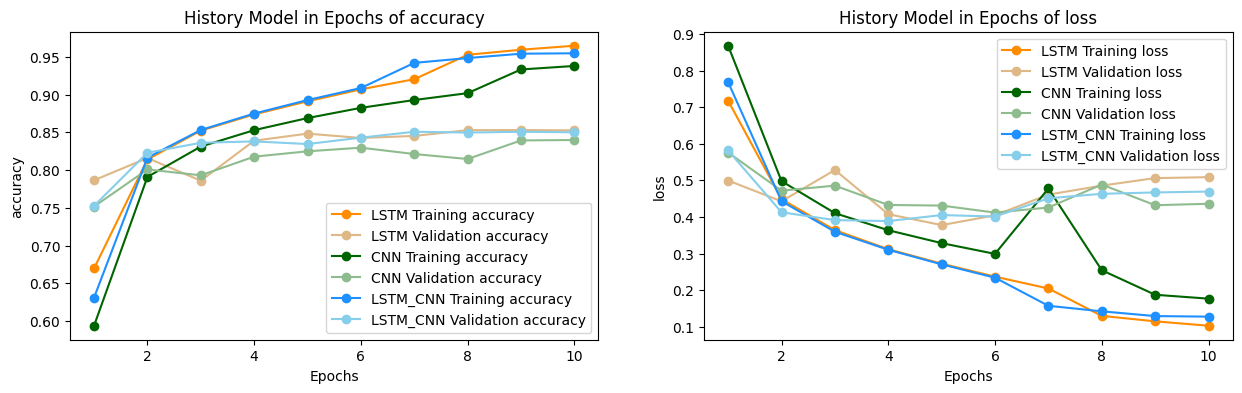

In [ ]:
plot_compare_graphs([history_lstm, history_cnn, history_lstm_cnn], ['LSTM', 'CNN', 'LSTM_CNN'])

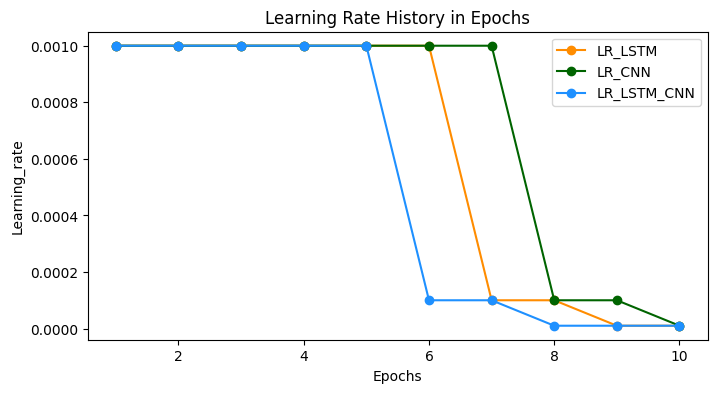

In [ ]:
lr_history_plot([lr_history_lstm, lr_history_cnn, lr_history_lstm_cnn], ['LR_LSTM', 'LR_CNN', 'LR_LSTM_CNN'])

# Saving best checkpoint model

In [ ]:
!zip -r ckpt.zip /tmp/ckpt
models_to_download = 'ckpt.zip'
try:
  files.download('training.log')
  files.download(models_to_download)

except e:
  print(e)

# END TRAINING HERE, BE CAREFUL TO RUN CELLS ABOVE

# Evaluate the model

In [33]:
def download_model():
  model_url = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/rnn-cnn-comparing/model/checkpoint_lstm-10-0.965-0.853.keras'
  # Find the position of the last forward slash '/'
  last_slash_index = model_url.rfind('/')

  # Extract the substring from the last slash to the end of the string
  model_name = model_url[last_slash_index + 1:]
  urllib.request.urlretrieve(model_url, model_name)
  print('Downloading model...')
  print('Success downloading model')
  return model_name

model_path = download_model()

Success downloading model


In [35]:
# loaded trained model
loaded_model = tf.keras.models.load_model(model_path)
loaded_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 100, 250)            │      12,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         161,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 50)                  │           6,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,335,768 (96.65 MB)

 Trainable params: 12,667,883 (48.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,667,885 (48.32 MB)

In [37]:
loss, accuracy = loaded_model.evaluate(test_set)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8491 - loss: 0.5122
Loss: 0.5015486478805542
Accuracy: 0.8535000085830688


## Visualize Word Embeddings

Get embedding layer weights for visualization

In [38]:
# get embedding layer
embedding_layer = loaded_model.layers[0]

# get weights of embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# print shape of embedding layer
print(embedding_weights.shape)
print(embedding_weights)

(50000, 250)
[[ 0.03853265  0.01942185 -0.02474937 ...  1.1579858  -0.07753779
  -0.18056215]
 [ 0.03398724  0.05672573 -0.10087847 ... -0.02539834 -0.01216442
  -0.04096499]
 [ 0.03369459  0.01598563 -0.47398221 ... -0.10472018 -0.07684373
  -0.06080074]
 ...
 [ 0.04423078  0.01821558  0.03807574 ...  0.02972095  0.02016854
  -0.00134145]
 [-0.00797966  0.04170838 -0.02950444 ... -0.04077731  0.03563902
   0.04510329]
 [-0.00458356  0.03608023 -0.01156332 ... -0.01583562  0.00960868
   0.00491071]]


Visit [Tensorflow Embedding Projector](https://projector.tensorflow.org/) for visualize the embedding word

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for i in range(1, vocab_size):
  # get word names from tokenizer dictionary of index word
  # {1: 'word',...}
  word_name = tokenizer.index_word[i]

  # get word embeddings, shape of (10000, 24)
  word_embeddings = embedding_weights[i]

  # write word name in each line of the file
  out_m.write(word_name + '\n')

  # write word embeddings of 24 dims in each training data
  out_v.write('\t'.join([str(x) for x in word_embeddings]) + '\n')

# close the file
out_v.close()
out_m.close()

Download vecs.tsv and meta.tsv files for uploading to tensorflow embedding projector to visualize

In [ ]:
try:
  files.download('vecs.tsv')
  files.download('meta.tsv')
except e:
  print(e)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prediction

In [39]:
# predict the test labels from dataset

# show prediction softmax probability in each data
predictions = loaded_model.predict(padded_test)
print(predictions)

938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
[[1.7358719e-06 1.5050019e-01 8.4949803e-01]
 [7.9531848e-09 5.0421502e-05 9.9994957e-01]
 [1.2694217e-07 5.7590879e-03 9.9424076e-01]
 ...
 [9.9999774e-01 2.3032660e-06 1.4448315e-10]
 [2.6134672e-03 5.9767377e-02 9.3761921e-01]
 [5.3859407e-07 2.8824043e-03 9.9711704e-01]]


## Confussion Matrix

In [ ]:
labels_encoder

{0: 'positive', 1: 'neutral', 2: 'negative'}

In [ ]:
np.unique(test_labels)

array([0, 1, 2])

In [51]:
# Return the highest softmax prob index
pred_labels = np.argmax(predictions, axis=1)
print(f'pred labels: {pred_labels[:10]}')
# flatten the test labels
test_labels = test_labels.flatten()
print(f'test labels: {test_labels[:10]}')



con_mat = tf.math.confusion_matrix(labels=test_labels,
                                   predictions=pred_labels).numpy()

print(f'confusion matrix values: \n{con_mat}')

pred labels: [2 2 2 0 2 1 0 1 1 0]
test labels: [2 2 1 0 2 1 0 1 1 0]
confusion matrix values: 
[[8927 1004   69]
 [1033 7863 1104]
 [  59 1126 8815]]


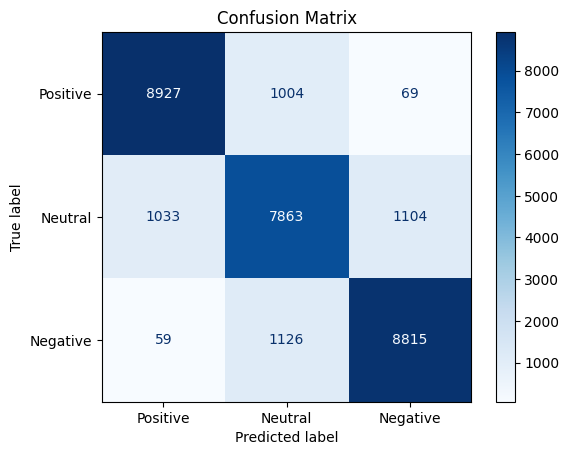

In [42]:
con_mat_disp = ConfusionMatrixDisplay(con_mat, display_labels=['Positive','Neutral', 'Negative'])
con_mat_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Label Binarize

In [43]:
# Assuming test_labels and predictions are given
# test_labels: Actual labels (e.g., [0, 1, 2, 0, 2])
# predictions: Predicted probabilities for each class (e.g., shape [n_samples, n_classes])

# Binarize the labels for a one-vs-rest approach
n_classes = predictions.shape[1]

#converts the original test_labels into a one-hot encoded format.
test_labels_bin = label_binarize(test_labels, classes=np.arange(n_classes))

## ROC Curve (One vs the Rest)

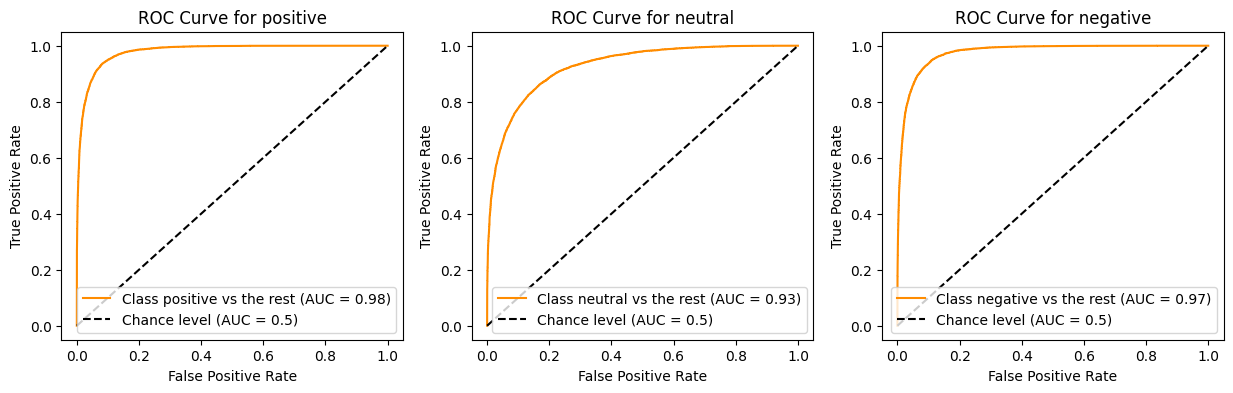

In [44]:
from sklearn.metrics import RocCurveDisplay

fig, axes = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)

for i in range(n_classes):
  # display roc curve from prediction
  display = RocCurveDisplay.from_predictions(
      test_labels_bin[:, i],
      predictions[:, i],
      name=f'Class {labels_encoder[i]} vs the rest',
      color="darkorange",
      plot_chance_level=True,
      ax = axes[i]
  )

  display.ax_.set(
      title=f'ROC Curve for {labels_encoder[i]}',
      xlabel='False Positive Rate',
      ylabel='True Positive Rate',
  )

plt.show()


## Precision, Recall, F1 score

In [45]:
precision_score = precision_score(test_labels, pred_labels, average='micro')
recall_score = recall_score(test_labels, pred_labels, average='micro')
f1_score = f1_score(test_labels, pred_labels, average='micro')

Precision for class positive: [0.33333333 0.33334444 0.33335556 ... 1.         1.         1.        ]
Recall for class positive: [1.e+00 1.e+00 1.e+00 ... 5.e-04 2.e-04 0.e+00]
Thresholds for class positive: [8.5620443e-13 9.4919396e-13 1.3535146e-12 ... 9.9999928e-01 9.9999940e-01
 9.9999952e-01]

Precision for class neutral: [0.33333333 0.33334444 0.33335556 ... 1.         1.         1.        ]
Recall for class neutral: [1.e+00 1.e+00 1.e+00 ... 5.e-04 2.e-04 0.e+00]
Thresholds for class neutral: [8.5620443e-13 9.4919396e-13 1.3535146e-12 ... 9.9999928e-01 9.9999940e-01
 9.9999952e-01]

Precision for class negative: [0.33333333 0.33334444 0.33335556 ... 1.         1.         1.        ]
Recall for class negative: [1.e+00 1.e+00 1.e+00 ... 5.e-04 2.e-04 0.e+00]
Thresholds for class negative: [8.5620443e-13 9.4919396e-13 1.3535146e-12 ... 9.9999928e-01 9.9999940e-01
 9.9999952e-01]

Precision Score: 0.8535
Recall Score: 0.8535
F1 Score: 0.8535


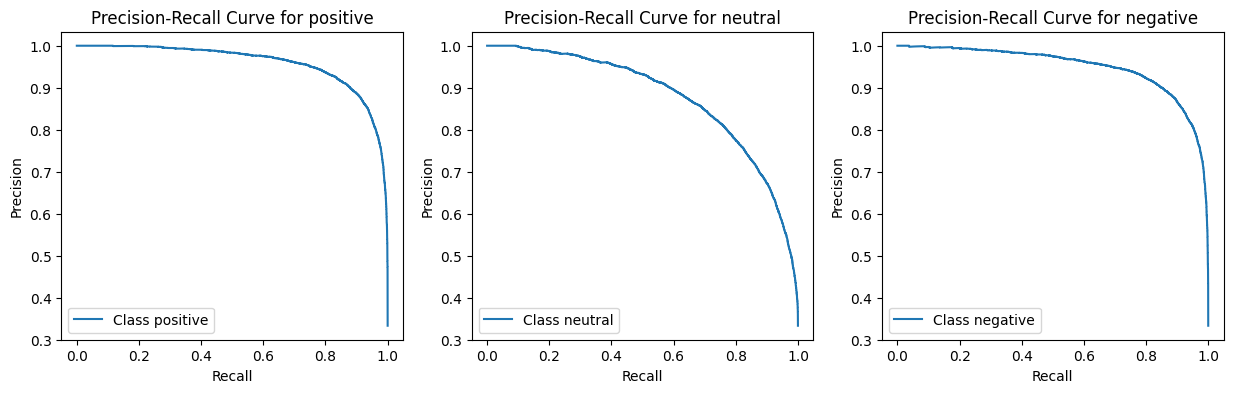

In [46]:
# Store precision, recall, thresholds for each class
precision_dict = {}
recall_dict = {}
thresholds_dict = {}

# set the figures for plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

for i in range(n_classes):
    # Calculate precision, recall, and thresholds for each class
    precision, recall, thresholds = precision_recall_curve(test_labels_bin[:, i], predictions[:, i])

    # store values of precision, recall, and thresholds in dictionaries
    precision_dict[i] = precision
    recall_dict[i] = recall
    thresholds_dict[i] = thresholds

    # display the corresponden values
    display = PrecisionRecallDisplay(
        recall=recall_dict[i],
        precision=precision_dict[i]
    )

    display.plot(ax=ax[i], name=f'Class {labels_encoder[i]}')
    ax[i].set_title(f'Precision-Recall Curve for {labels_encoder[i]}')
    ax[i].set_xlabel('Recall')
    ax[i].set_ylabel('Precision')

    # print
    print(f'Precision for class {labels_encoder[i]}: {precision_dict[0]}')
    print(f'Recall for class {labels_encoder[i]}: {recall_dict[0]}')
    print(f'Thresholds for class {labels_encoder[i]}: {thresholds_dict[0]}\n')


# print macro-average of precision, recall, f1 score
print(f'Precision Score: {precision_score}')
print(f'Recall Score: {recall_score}')
print(f'F1 Score: {f1_score}')

## Input user

In [50]:
user_input = input('Enter a sentence: ')

# tokenize the sentence
user_sequence = tokenizer.texts_to_sequences([user_input])

# pad the sequence
user_padded = pad_sequences(user_sequence, maxlen=max_length, truncating='post', padding='post')

# predict the sentiment
prediction = loaded_model.predict(user_padded)

# -- - Summary prediciton ---
print('---- Prediction summary -----')
print(labels_encoder)
print('Softmax probability:', prediction[0])

# return the highest probability of 3 categories
predicted_index = np.argmax(prediction, axis=1)

# get the predicted label based on highest probability
predicted_label = labels_encoder[predicted_index[0]]
print(f'Predicted sentiment: {predicted_label}')

Enter a sentence: baby, i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
---- Prediction summary -----
{0: 'positive', 1: 'neutral', 2: 'negative'}
Softmax probability: [0.98055995 0.01825619 0.00118392]
Predicted sentiment: positive



# Deployment

## Using Pickle

In [ ]:
with open('model.pkl', 'wb') as file:
  pickle.dump(loaded_model, file)

In [ ]:
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>